# Adverserial(Variational) AutoEncoder
<img src="./asset/Figure_1.png" width="700" height="500">


- VAE가 GAN의 generator의 역할을 수행. encoder는 데이터 $x$를 받아서 잠재변수 $z$를 샘플링하고, 생성자의 decoder는 $x$를 복원함.
- 차이점은 GAN의 discriminator역할을 하는 네트워크가 추가됨. discriminator는 generator의 encoder가 샘플링한 가짜 $z$와 $p(z)$로부터 직접 샘플링한 진짜 $z$를 구분하는 역할을 수행
- VAE의 regularization term을 GAN Loss로 대체할 경우 prior와 posterior를 정규분포 이외의 다른 분포를 사용할 수 있게 됨. 

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid

import os
import matplotlib.pyplot as plt
%matplotlib inline

USE_CUDA = torch.cuda.is_available()

## 2. Load Dataset

In [2]:
result_dir = './save_results/MNIST/AAE'
model_dir = './save_models/MNIST/AAE'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)


mnist_train = dset.MNIST('./data/MNIST', train=True, transform=transforms.ToTensor(), target_transform=None,download=True)
mnist_test = dset.MNIST('./data/MNIST', train=False, transform=transforms.ToTensor(), target_transform=None,download=True)

batch_size = 64

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

## 3. Build Model
### 3.1 Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, X_dim, h_dim, z_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(X_dim, h_dim)
        self.linear2 = nn.Linear(h_dim, z_dim)
        
    def forward(self, inputs):
        out = F.relu(self.linear1(inputs))
        out = self.linear2(out)
        return out

### 3.2 Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self, X_dim, h_dim, z_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(z_dim, h_dim)
        self.linear2 = nn.Linear(h_dim, X_dim)
        
    def forward(self, inputs):
        out = F.relu(self.linear1(inputs))
        out = F.sigmoid(self.linear2(out))
        return out

### 3.3 Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self, h_dim, z_dim):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(z_dim, h_dim)
        self.linear2 = nn.Linear(h_dim, 1)
        
    def forward(self, inputs):
        out = F.relu(self.linear1(inputs))
        out = F.sigmoid(self.linear2(out))
        return out

In [6]:
X_dim = 784
h_dim = 128
z_dim = 5
lr = 1e-3

sample_z = Variable(torch.randn((batch_size, X_dim)), volatile=True)

Q = Encoder(X_dim, h_dim, z_dim)
P = Decoder(X_dim, h_dim, z_dim)
D = Discriminator(h_dim, z_dim)

if USE_CUDA:
    Q = Q.cuda()
    P = P.cuda()
    D = D.cuda()
    sample_z = sample_z.cuda()

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


## 4. Loss func & Optims

In [7]:
Q_solver = optim.Adam(Q.parameters(), lr=lr)
P_solver = optim.Adam(P.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

def reset_grad():
    Q_solver.zero_grad()
    P_solver.zero_grad()
    D_solver.zero_grad()
    
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [8]:
try:
    Q.load_state_dict(torch.load(model_dir + '/AAE_encoder.pkl'))
    P.load_state_dict(torch.load(model_dir + '/AAE_decoder.pkl'))
    D.load_state_dict(torch.load(model_dir + '/AAE_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 5. Train

In [9]:
num_epoch = 50
total_batch = len(train_loader.dataset)//batch_size
for epoch in range(num_epoch + 1): # num_epoch
    for i, (image, label) in enumerate(train_loader):
        image = image.view(batch_size, -1) # 128 x 784
        
        if USE_CUDA:
            image = image.cuda()
        
        #================== Reconstruction ==================
        z_sample = Q(image)
        X_sample = P(z_sample)
        
        recon_loss = F.binary_cross_entropy(X_sample, image)
        recon_loss.backward()
        Q_solver.step()
        P_solver.step()
        reset_grad()
        
        #================== Regularization ==================
        # Discriminator
        z_real = Variable(torch.randn(batch_size, z_dim))
        
        if USE_CUDA:
            z_real = z_real.cuda()
        
        z_fake = Q(image)
        
        D_real = D(z_real)
        D_fake = D(z_fake)
        
        D_loss = -torch.mean(torch.log(D_real) + torch.log(1 - D_fake))
        
        D_loss.backward()
        D_solver.step()
        reset_grad()
        
        # Generator
        z_fake = Q(image)
        D_fake = D(z_fake)
        
        G_loss = -torch.mean(torch.log(D_fake))
        
        G_loss.backward()
        Q_solver.step()
        reset_grad()
        
        if (i+1) % 300 == 0:
            print('Epoch [%d/%d], Step[%d/%d], D_loss: %.4f, G_loss: %.4f, recon_loss: %.4f'
              %(epoch, num_epoch, i+1, total_batch, D_loss.data[0], G_loss.data[0], recon_loss.data[0]))
            
            # Save the trained parameters
            torch.save(Q.state_dict(), model_dir + '/AAE_encoder.pkl')
            torch.save(P.state_dict(), model_dir + '/AAE_decoder.pkl')
            torch.save(D.state_dict(), model_dir + '/AAE_discriminator.pkl')
    
    # Save real images
    Q.eval()
    P.eval()
    samples = Q(sample_z)
    samples = P(samples)
    
    if (epoch+1) == 1:
        image = image.view(image.size(0), 1, 28, 28) # z_dim x batch_size
        #save_image(denorm(image.data), result_dir +'/real_images.png')
        save_image(image.data, result_dir +'/real_images.png')
        
    # Save sampled images
    fake_image = samples.view(samples.size(0), 1, 28, 28)
    # save_image(denorm(fake_image.data), result_dir +'/fake_images-%d.png' %(epoch+1))
    save_image(fake_image.data, result_dir +'/fake_images-%d.png' %(epoch+1))

/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [0/50], Step[300/937], D_loss: 1.5870, G_loss: 0.6641, recon_loss: 0.2693
Epoch [0/50], Step[600/937], D_loss: 1.5497, G_loss: 0.6799, recon_loss: 0.2686
Epoch [0/50], Step[900/937], D_loss: 1.5162, G_loss: 0.7309, recon_loss: 0.2559
Epoch [1/50], Step[300/937], D_loss: 1.3916, G_loss: 0.7011, recon_loss: 0.2386
Epoch [1/50], Step[600/937], D_loss: 1.6569, G_loss: 0.4897, recon_loss: 0.2705
Epoch [1/50], Step[900/937], D_loss: 1.4601, G_loss: 0.6173, recon_loss: 0.2762
Epoch [2/50], Step[300/937], D_loss: 1.5168, G_loss: 0.6577, recon_loss: 0.2461
Epoch [2/50], Step[600/937], D_loss: 1.4261, G_loss: 0.6571, recon_loss: 0.2270
Epoch [2/50], Step[900/937], D_loss: 1.4674, G_loss: 0.5915, recon_loss: 0.2394
Epoch [3/50], Step[300/937], D_loss: 1.4395, G_loss: 0.6391, recon_loss: 0.2071
Epoch [3/50], Step[600/937], D_loss: 1.3887, G_loss: 0.6895, recon_loss: 0.1998
Epoch [3/50], Step[900/937], D_loss: 1.3950, G_loss: 0.6904, recon_loss: 0.2100
Epoch [4/50], Step[300/937], D_loss: 1.3

Epoch [34/50], Step[300/937], D_loss: 1.3854, G_loss: 0.6888, recon_loss: 0.1623
Epoch [34/50], Step[600/937], D_loss: 1.3881, G_loss: 0.6957, recon_loss: 0.1375
Epoch [34/50], Step[900/937], D_loss: 1.3852, G_loss: 0.6956, recon_loss: 0.1418
Epoch [35/50], Step[300/937], D_loss: 1.3838, G_loss: 0.6932, recon_loss: 0.1468
Epoch [35/50], Step[600/937], D_loss: 1.3871, G_loss: 0.6933, recon_loss: 0.1533
Epoch [35/50], Step[900/937], D_loss: 1.3933, G_loss: 0.6897, recon_loss: 0.1602
Epoch [36/50], Step[300/937], D_loss: 1.3853, G_loss: 0.6932, recon_loss: 0.1466
Epoch [36/50], Step[600/937], D_loss: 1.3792, G_loss: 0.6963, recon_loss: 0.1465
Epoch [36/50], Step[900/937], D_loss: 1.3963, G_loss: 0.6870, recon_loss: 0.1577
Epoch [37/50], Step[300/937], D_loss: 1.3879, G_loss: 0.6932, recon_loss: 0.1665
Epoch [37/50], Step[600/937], D_loss: 1.3905, G_loss: 0.6904, recon_loss: 0.1497
Epoch [37/50], Step[900/937], D_loss: 1.3890, G_loss: 0.6883, recon_loss: 0.1549
Epoch [38/50], Step[300/937]

## 6. Check Train Image


 from train data image



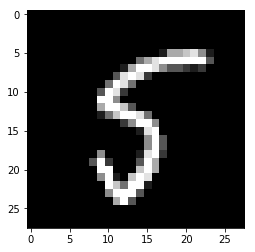


 from generated model's image



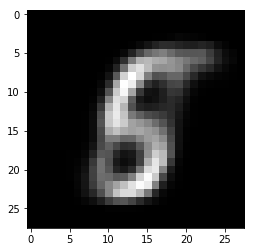


 from train data image



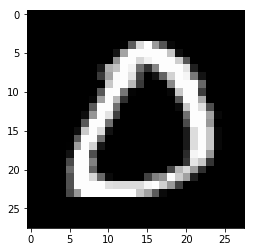


 from generated model's image



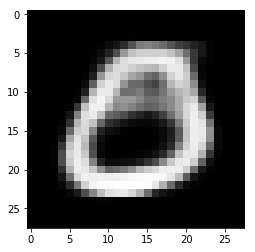


 from train data image



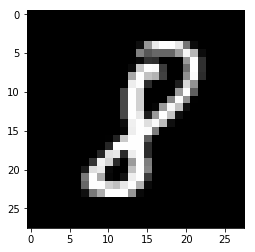


 from generated model's image



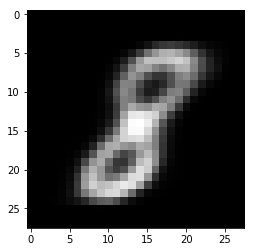


 from train data image



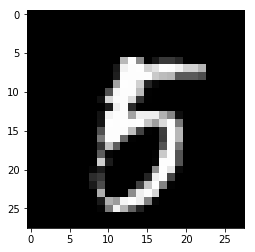


 from generated model's image



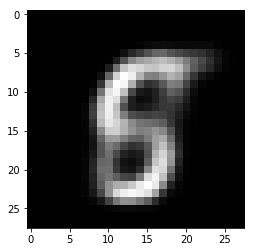


 from train data image



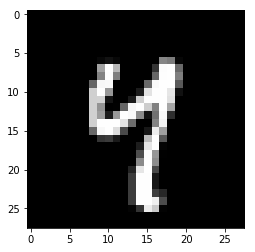


 from generated model's image



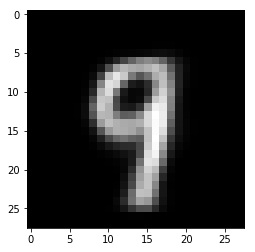

In [10]:
out_image = X_sample.view(batch_size, 28, 28).cpu().data
image = image.view(batch_size, 28, 28).cpu().data

for i in range(5):
    print("\n from train data image\n")
    plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(), cmap='gray')
    plt.show()
    print("\n from generated model's image\n")
    plt.imshow(out_image[i].numpy(), cmap='gray')
    plt.show()

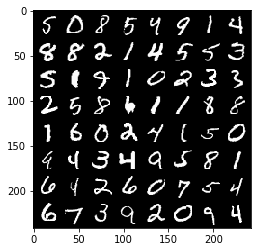

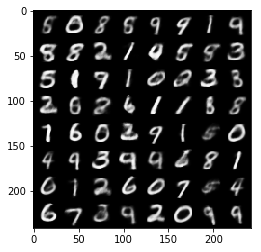

In [11]:
plt.imshow(make_grid(image.data.view(batch_size,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()

plt.imshow(make_grid(X_sample.data.view(batch_size,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()

## 7. Display Generated Data

In [12]:
import imageio

images = []
for epoch in range(num_epoch + 1):
    try:
        img_name = result_dir +'/fake_images-%d.png' %(epoch+1)
        images.append(imageio.imread(img_name))
    except:
        pass

imageio.mimsave(result_dir + '/fake_images_total.gif', images, fps=4)

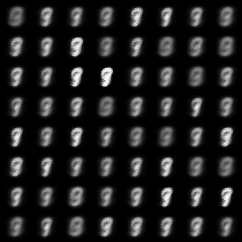

In [13]:
from IPython.display import Image

with open(result_dir + '/fake_images_total.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))